In [ ]:
%matplotlib inline


# Rhythmic Entrainment Source Separation (RESS) example

Find the linear combinations of multichannel data that maximize the
signal-to-noise ratio of the narrow-band steady-state response in the frequency
domain.

Uses `meegkit.RESS()`.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as ss
from meegkit import ress
from meegkit.utils import fold, matmul3d, rms, snr_spectrum, unfold

# import config

np.random.seed(1)

## Create synthetic data
Create synthetic data containing a single oscillatory component at 12 hz.



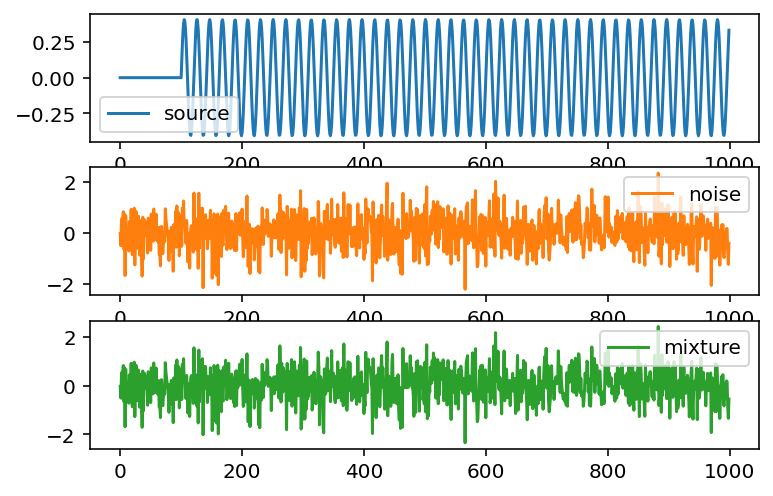

In [2]:
n_times = 1000
n_chans = 10
n_trials = 30
target = 12
sfreq = 250
noise_dim = 8
SNR = .2
t0 = 100

# source
source = np.sin(2 * np.pi * target * np.arange(n_times - t0) / sfreq)[None].T
s = source * np.random.randn(1, n_chans)
s = s[:, :, np.newaxis]
s = np.tile(s, (1, 1, n_trials))
signal = np.zeros((n_times, n_chans, n_trials))
signal[t0:, :, :] = s

# noise
noise = np.dot(
    unfold(np.random.randn(n_times, noise_dim, n_trials)),
    np.random.randn(noise_dim, n_chans))
noise = fold(noise, n_times)

# mix signal and noise
signal = SNR * signal / rms(signal.flatten())
noise = noise / rms(noise.flatten())
data = signal + noise

# Plot
f, ax = plt.subplots(3)
ax[0].plot(signal[:, 0, 0], c='C0', label='source')
ax[1].plot(noise[:, 1, 0], c='C1', label='noise')
ax[2].plot(data[:, 1, 0], c='C2', label='mixture')
ax[0].legend()
ax[1].legend()
ax[2].legend()

## Enhance oscillatory activity using RESS



(0.0, 40.0)

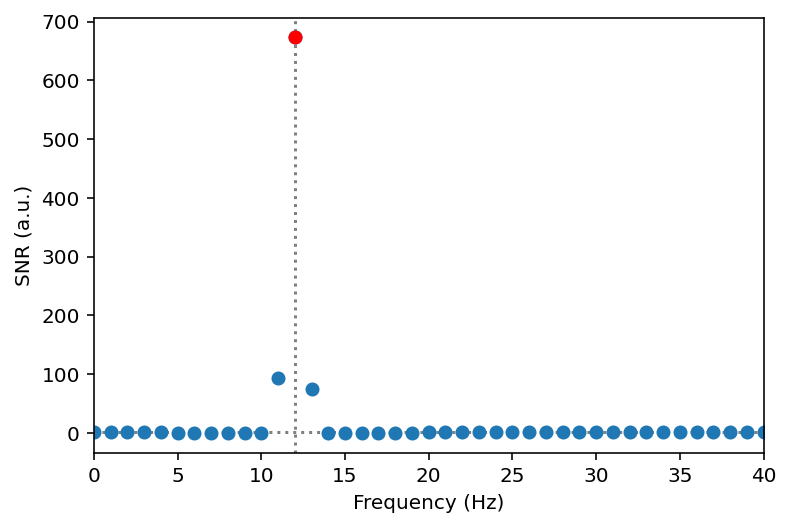

In [3]:
# Apply RESS
out, maps = ress.RESS(data, sfreq=sfreq, peak_freq=target, return_maps=True)

# Compute PSD
nfft = 250
df = sfreq / nfft  # frequency resolution
bins, psd = ss.welch(out.squeeze(1), sfreq, window="hamming", nperseg=nfft,
                     noverlap=125, axis=0)
psd = psd.mean(axis=1, keepdims=True)  # average over trials
snr = snr_spectrum(psd, bins, skipbins=2, n_avg=2)

f, ax = plt.subplots(1)
ax.plot(bins, snr, 'o', label='SNR')
ax.plot(bins[bins == target], snr[bins == target], 'ro', label='Target SNR')
ax.axhline(1, ls=':', c='grey', zorder=0)
ax.axvline(target, ls=':', c='grey', zorder=0)
ax.set_ylabel('SNR (a.u.)')
ax.set_xlabel('Frequency (Hz)')
ax.set_xlim([0, 40])

Project components back into sensor space to see the effects of RESS on the
average SSVEP.



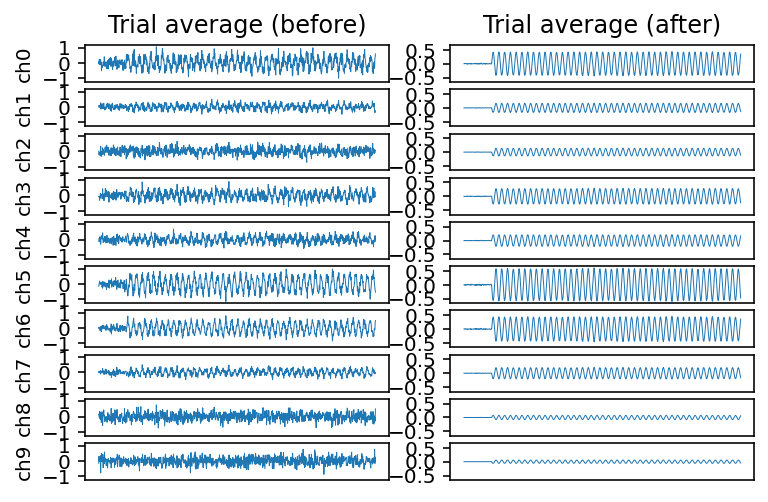

In [4]:
proj = matmul3d(out, maps.T)
f, ax = plt.subplots(n_chans, 2, sharey='col')
for c in range(n_chans):
    ax[c, 0].plot(data[:, c].mean(-1), lw=.5)
    ax[c, 1].plot(proj[:, c].mean(-1), lw=.5)
    ax[c, 0].set_ylabel(f'ch{c}')
    if c < n_chans:
        ax[c, 0].set_xticks([])
        ax[c, 1].set_xticks([])

ax[0, 0].set_title('Trial average (before)')
ax[0, 1].set_title('Trial average (after)')
plt.show()